In [5]:
import torch
from snn_delays.snn import SNN
from snn_delays.experimental_models.snn_binary import TH_BinarySNN, BinarySNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.model_loader import ModelLoader
from snn_delays.utils.train_utils import train, get_device, propagate_batch
from snn_delays.utils.visualization_utils import plot_raster
from snn_delays.utils.test_behavior import tb_save_max_last_acc
import matplotlib.pyplot as plt

device = get_device()

# For reproducibility
torch.manual_seed(10)

Running on: cuda:0


In [6]:
### DATASET

# Parameters
dataset = 'nmnist'
total_time = 50
batch_size = 1024

# Resized dataloader
# DATASET
DL = DatasetLoader(dataset=dataset,
                   caching='memory',
                   num_workers=0,
                   batch_size=batch_size,
                   total_time=total_time, 
                   sensor_size_to=16)

train_loader, test_loader, dataset_dict = DL.get_dataloaders()

[Downsample(time_factor=1, spatial_factor=0.47058823529411764, sensor_size=None, target_size=None), ToFrame(sensor_size=(16, 16, 2), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]


In [9]:
#snn_full = ModelLoader('full_weights_stmnist50_SNN_l1_1d1.t7_874820143884892_max_92epoch','exp_snn2chip', batch_size, device, True) # without bias
snn_full = ModelLoader('full_weights_(64, 1)nmnist50_l1_1d1.t7_9671_max_10epoch','exp_snn2chip_nmnist', batch_size, device, True) # with bias
snn_full.test(train_loader)

### SPIKING NEURAL NETWORK
structure = snn_full.structure
dataset_dict["time_ms"] = 2e3
loss_fn = snn_full.loss_fn

print(loss_fn)

binary_mode = 'binary'

snn = BinarySNN(dataset_dict=dataset_dict, structure=structure, connection_type='f',
          delay=None, delay_type='', tau_m='normal', binary_mode=binary_mode,
          reset_to_zero=True, win=total_time, bias=False,
          loss_fn=loss_fn, batch_size=batch_size, device=device,
          debug=True)
snn.set_network()

snn.input2spike_th = None

#snn.to(device)
snn.model_name = 'trainable_threshold_' + snn.model_name

if snn_full.bias:
    weight_taus = [(name, w) for name, w  in snn.named_parameters() if 'th' not in name]
    weight_taus_origin = [(name, w) for name, w  in snn_full.named_parameters() if 'th' not in name]
else:
    weight_taus = [(name, w) for name, w  in snn.named_parameters() if 'th' not in name and 'bias' not in name]
    weight_taus_origin = [(name, w) for name, w  in snn_full.named_parameters() if 'th' not in name]

for (name_src, param_src), (name_dst, param_dst) in zip(weight_taus_origin, weight_taus):
    assert name_src == name_dst, f"Parameter mismatch: {name_src} != {name_dst}"
    param_dst.data.copy_(param_src.data)

print(weight_taus)

snn.to(device)

num_epochs = 30
lr = 1e-3
ckpt_dir = 'exp_snn2chip_nmnist'

train(snn, train_loader, test_loader, lr, num_epochs, dropout=0.0, 
    test_behavior=tb_save_max_last_acc, ckpt_dir=ckpt_dir, scheduler=(10, 0.95), test_every=1, freeze_taus=True)


[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
2000.0
Delta t: 40.0 ms
mean of normal: -1.8545865421311407
Instance of <class 'snn_delays.snn.SNN'> loaded successfully
Test Loss: 0.06772009276990164
Avg spk_count per neuron for all 50 time-steps 11.663139343261719
Avg spk per neuron per layer [11.663139583333333]
Test Accuracy of the model on the test samples: 98.245

mem_sum

[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
2000.0
Delta t: 40.0 ms
mean of normal: -1.8545865421311407
[('tau_m_1', Parameter containing:
tensor([-1.9415, -2.5073, -0.6494, -2.8467, -0.9711, -2.4298, -1.6901, -3.7156,
        -2.1936, -4.1898, -3.2807, -0.6259, -2.3801, -3.0715, -2.3004, -1.0424,
        -2.5696, -2.0972, -1.2340, -1.0782, -1.1520, -2.0014, -3.6134,  0.3125,
        -3.4396, -2.0757, -3.0003, -3.5524, -1.6176, -1.6956, -0.7205, -1.1180,
        -4.5041, 

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [19/58], Loss: 2.21089
l1_score: 0
Step [38/58], Loss: 1.98187
l1_score: 0
Step [57/58], Loss: 1.84306
l1_score: 0
Time elasped: 17.35828709602356
Test Loss: 1.8096259593963624
Avg spk_count per neuron for all 50 time-steps 8.481465339660645
Avg spk per neuron per layer [8.481465625]
Test Accuracy of the model on the test samples: 49.980

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\exp_snn2chip_nmnist
saving max acc: 49.98
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\exp_snn2chip_nmnist
Epoch [2/30], learning_rates 0.001000, 0.100000
Step [19/58], Loss: 1.71025
l1_score: 0
Step [38/58], Loss: 1.61020
l1_score: 0
Step [57/58], Loss: 1.50158
l1_score: 0
Time elasped: 18.2134268283844
Test Loss: 1.51542809009552
Avg spk_count per neuron for all 50 time-steps 9.555710792541504
Avg spk per neuron per layer [9.5557109375]
Test Accuracy of the model on the test samples: 57.470

Model saved in  C:\U

In [6]:
snn_full.f0_f1

Linear(in_features=200, out_features=64, bias=False)

Test Loss: 0.33007449805736544
Avg spk_count per neuron for all 50 time-steps 19.284345626831055
Avg spk per neuron per layer [19.2843453125]
Test Accuracy of the model on the test samples: 90.010


[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
2000.0
Delta t: 40.0 ms
mean of normal: -1.8545865421311407
tensor(0.3048, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5035, device='cuda:0', grad_fn=<MeanBackward0>)


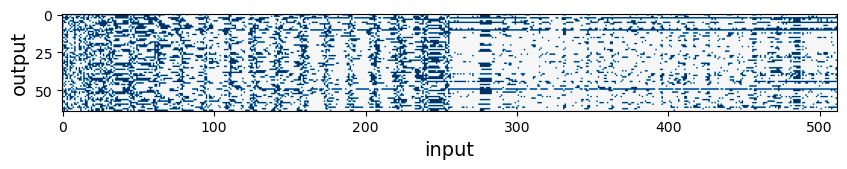

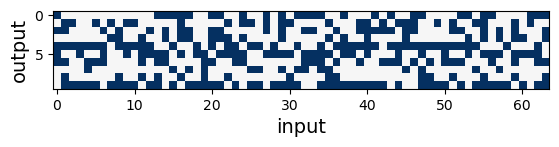

Test Loss: 0.3304518938064575
Avg spk_count per neuron for all 50 time-steps 19.284345626831055
Avg spk per neuron per layer [19.2843453125]
Test Accuracy of the model on the test samples: 90.010



In [11]:
from snn_delays.utils.train_utils import copy_snn
from snn_delays.utils.visualization_utils import plot_param, plot_distributions

# snn_test = copy_snn(snn, batch_size)
# snn_test.debug = True
a, b = snn.test(test_loader)

snn_test = SNN(dataset_dict=dataset_dict, structure=structure, connection_type='f',
          delay=None, delay_type='', tau_m='normal',
          reset_to_zero=True, win=total_time,
          loss_fn=loss_fn, batch_size=batch_size, device=device,
          debug=True)
snn_test.set_network()

weight_taus = [(name, w) for name, w  in snn_test.named_parameters() if 'th' not in name]
for (name_src, param_src), (name_dst, param_dst) in zip(snn.named_parameters(), weight_taus):
    assert name_src == name_dst, f"Parameter mismatch: {name_src} != {name_dst}"
    param_dst.data.copy_(param_src.data)

w_params = [w for name, w  in snn_test.named_parameters() if 'f' in name]

for w in w_params:
    scale = w.abs().mean()
    print(scale)
    if binary_mode == 'binary':
        w.data = (w.data > 0.0).float().mul(scale).mul(0.3)
    #w.data = (w.data > 0.0).float().mul(scale)
    elif binary_mode == 'sign':
        w.data = w.data.mul(scale).sign().mul(scale)
    elif binary_mode == 'relu':
        w.data = w.data.clamp(0, 1).mul(scale)
        #w.data = w.data
    #w.data = (w.data > 0.0).float().mul(scale*0.3)


plt.figure(figsize=(10,10))
for w in w_params:
    plot_param(w, '2D')
    plt.show()

a, b =snn_test.test(test_loader)
